## The Goal: Similar analysis as before, but use magnitude of full surface winds (U and V) and sum of their variances. 
<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 19 Sept 2020 
<br>

In [211]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
#import Ngl
#import Nio
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import regionmask
import pickle
from sklearn.linear_model import LinearRegression


## Read in data

In [212]:
# Set up directories 
dataDir    = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/'
nameStart  = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.'
nameEnd    = '_CLUBBwinds.nc'
nameEnd_UV = '_UV.nc'
nameEnd_W  = '_W.nc'
nameEnd_PBLH = '_PBLH.nc'

#decadeList = ['1951-59','1960-69', '1970-79','1980-89','1990-99','2000-14']
decadeList = ['1970-79','1980-89','1990-99','2000-14']


In [213]:
# Read in example file to get some constant fields
testName = dataDir+nameStart+'1990-01.nc'
testDF   = xr.open_dataset(testName)

# Set lat, lon 
lat = testDF.lat
lon = testDF.lon

# Make land mask
landFrac = np.squeeze(testDF.LANDFRAC.values)
# Define as 'land' gridcell if land fraction > 0.5
landMask = np.full([len(lat),len(lon)],np.nan)
landMask[landFrac > 0.5] = 1


In [214]:
# Read in data by decade 
for iDec in range(len(decadeList)): 
    
    # Open datasets for each decade 
    fileName = dataDir+nameStart+decadeList[iDec]+nameEnd
    dataDF   = xr.open_dataset(fileName, decode_times=True)
    dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    UVfile = dataDir+nameStart+decadeList[iDec]+nameEnd_UV 
    windDF = xr.open_dataset(UVfile, decode_times=True)
    windDF['time'] = windDF.indexes['time'].to_datetimeindex()
    
#     Wfile = dataDir+nameStart+decadeList[iDec]+nameEnd_W
#     vertDF = xr.open_dataset(Wfile, decode_times=True)
#     vertDF['time'] = vertDF.indexes['time'].to_datetimeindex()
    
#     PSfile = dataDir+nameStart+decadeList[iDec]+'_PS.nc'
#     presDF = xr.open_dataset(PSfile, decode_times=True)
#     presDF['time'] = presDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    PBLHfile = dataDir+nameStart+decadeList[iDec]+nameEnd_PBLH
    pblhDF   = xr.open_dataset(PBLHfile, decode_times=True)
    pblhDF['time'] = pblhDF.indexes['time'].to_datetimeindex()

    # Create *giant* datasets that span the full period of the simulations
    if iDec==0:
        fullDF = dataDF
        fullUV = windDF
        fullPBLH = pblhDF
#         fullW  = vertDF
#         fullPS = presDF
    else:
        fullDF = xr.concat([fullDF, dataDF], dim="time")
        fullUV = xr.concat([fullUV, windDF], dim="time")
        fullPBLH = xr.concat([fullPBLH, pblhDF], dim="time")
#         fullW  = xr.concat([fullW,  vertDF], dim="time")
#         fullPS = xr.concat([fullPS, presDF], dim="time")
        
    print('Done with decade ', decadeList[iDec], ' ... ')
    print('    Number of times saved: ', len(fullDF['time']))
    

<ipython-input-214-6b1e454e6717>:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime
<ipython-input-214-6b1e454e6717>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  windDF['time'] = windDF.indexes['time'].to_datetimeindex()
<ipython-input-214-6b1e454e6717>:23: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle er

Done with decade  1970-79  ... 
    Number of times saved:  120
Done with decade  1980-89  ... 
    Number of times saved:  240
Done with decade  1990-99  ... 
    Number of times saved:  360
Done with decade  2000-14  ... 
    Number of times saved:  540


In [215]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(fullDF['time'].values) 

# Let's set the monthly averages to be roughly mid-month
#   This way, the average for January has a month of 1 instead of being the first day of February 
midTime = dates - timedelta(days=15)       # Get new dates array that has the right month/year in it 


## Flip levels and do some minimal processing 

In [216]:
# Read into individual arrays for easy access

UP2 = fullDF.UP2_CLUBB.values      # Zonal velocity variance (m2/s2)
VP2 = fullDF.VP2_CLUBB.values      # Meridional velocity variance (m2/s2)
# WP2 = fullDF.WP2_CLUBB.values    # Vertical velocity variance (m2/s2)
# WP3 = fullDF.WP3_CLUBB.values    # Third moment vertical velocity (m3/s3)
PBLH = fullPBLH.PBLH.values

U   = fullUV.U.values              # Zonal wind (m/s)
V   = fullUV.V.values             # Meridional wind (m/s)
#W   = fullW.W.values              # Vertical velocity (m/s) -- script to compute on /glade/work/mdfowler/...



In [217]:
# Flip along vertical (level) axis, so that index 0 is surface 

UP2 = np.flip(UP2, axis=1)
VP2 = np.flip(VP2, axis=1)
# WP2 = np.flip(WP2, axis=1)
# WP3 = np.flip(WP3, axis=1)

U   = np.flip(U, axis=1)
V   = np.flip(V, axis=1)
#W   = np.flip(W, axis=1)

# Save levels themselves to arrays and flip them 
lev_interface = np.flip(fullDF.ilev.values)
lev_middle    = np.flip(fullUV.lev.values)


In [218]:
# Now get surface wind magnitude and combine variances 
windSpd = np.sqrt(U**2 + V**2)
windVar = UP2 + VP2 


In [219]:
# Sanity check that worked how I think it should 
print(windSpd[100,2,87,60])
print(np.sqrt( ((U[100,2,87,60])**2) + ((V[100,2,87,60])**2)  ))

7.0219536
7.021953423975367


## Start with a few maps of wind speed and variance 

In [220]:
# Get seasonal indices 
iDJF = np.where((midTime.month==12) | (midTime.month<=2))[0]
iMAM = np.where((midTime.month>=3)  & (midTime.month<=5))[0]
iJJA = np.where((midTime.month>=6)  & (midTime.month<=8))[0]
iSON = np.where((midTime.month>=9)  & (midTime.month<=11))[0]


In [221]:
# Select near surface speed and variance 
sfcWindSpd = windSpd[:,0,:,:]
sfcWindVar = windVar[:,1,:,:]


**Plot seasonal means**

In [222]:
# Compute means 
seasonalWindSpd = np.full([4, len(lat), len(lon)], np.nan)
seasonalWindVar = np.full([4, len(lat), len(lon)], np.nan)
seasonalTitles  = np.asarray(['DJF','MAM','JJA','SON'])

seasonalWindSpd[0,:,:] = np.nanmean(sfcWindSpd[iDJF,:,:], axis=0)
seasonalWindSpd[1,:,:] = np.nanmean(sfcWindSpd[iMAM,:,:], axis=0)
seasonalWindSpd[2,:,:] = np.nanmean(sfcWindSpd[iJJA,:,:], axis=0)
seasonalWindSpd[3,:,:] = np.nanmean(sfcWindSpd[iSON,:,:], axis=0)

seasonalWindVar[0,:,:] = np.nanmean(sfcWindVar[iDJF,:,:], axis=0)
seasonalWindVar[1,:,:] = np.nanmean(sfcWindVar[iMAM,:,:], axis=0)
seasonalWindVar[2,:,:] = np.nanmean(sfcWindVar[iJJA,:,:], axis=0)
seasonalWindVar[3,:,:] = np.nanmean(sfcWindVar[iSON,:,:], axis=0)


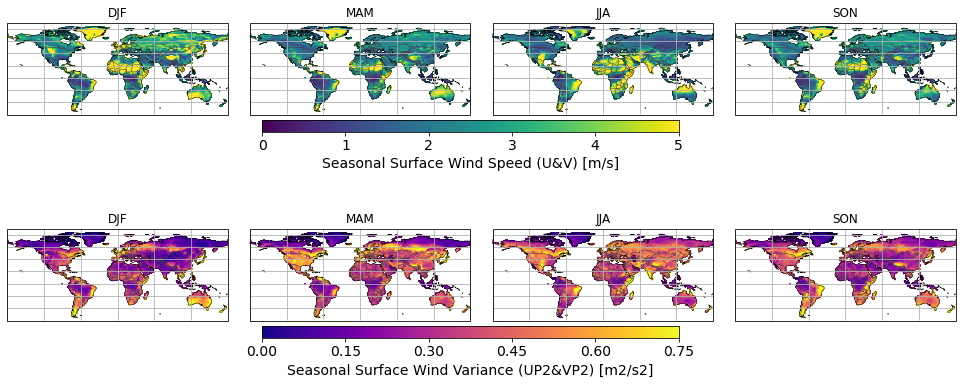

In [44]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# --- Start plotting ---- 
for iSeason in range(4): 
    axs[iSeason+0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())
    contour_plot = axs[iSeason+0].pcolormesh(lon,lat,seasonalWindSpd[iSeason,:,:]*landMask,
                           vmin = 0,
                           vmax = 5, 
                           cmap = 'viridis')
    axs[iSeason+0].gridlines()
    axs[iSeason+0].coastlines(linewidth=0.5,edgecolor='0.25')
    axs[iSeason+0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
    axs[iSeason+0].set_title(seasonalTitles[iSeason])
    
    # Add colorbar 
    if iSeason==1: 
        ax_position = axs[iSeason].get_position()
        cbar_ax     = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.03, ax_position.width+0.16, 0.02])
        cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
        # Control number of ticks via 'ticker' in matplotlib 
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        # Set label and fontsize
        cbar.set_label('Seasonal Surface Wind Speed (U&V) [m/s]',fontsize=14)
        cbar.ax.tick_params(labelsize=14)
    
    
    
    
    axs[iSeason+4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())
    contour_plot = axs[iSeason+4].pcolormesh(lon,lat,seasonalWindVar[iSeason,:,:]*landMask,
                           vmin = 0,
                           vmax = 0.75, 
                           cmap = 'plasma')
    axs[iSeason+4].gridlines()
    axs[iSeason+4].coastlines(linewidth=0.5,edgecolor='0.25')
    axs[iSeason+4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
    axs[iSeason+4].set_title(seasonalTitles[iSeason])
    
    # Add colorbar 
    if iSeason==1:
        ax_position = axs[iSeason+4].get_position()
        cbar_ax     = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.03, ax_position.width+0.16, 0.02])
        cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
        # Control number of ticks via 'ticker' in matplotlib 
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        # Set label and fontsize
        cbar.set_label('Seasonal Surface Wind Variance (UP2&VP2) [m2/s2]',fontsize=14)
        cbar.ax.tick_params(labelsize=14)
    
    


## Take a look at ratio of magnitude and SGS standard deviation 

In [45]:
# Get std rather than variance 
sfcWindStd = np.sqrt(sfcWindVar)

# Look at fraction of Ustd vs. magnitude of wind speed
STDfraction = sfcWindStd / (sfcWindSpd+sfcWindStd)  # Closer to 1 = std a bigger portion of U 


In [46]:
# Get seasonal means of that fraction 
seasonalStdFraction = np.full([4, len(lat), len(lon)], np.nan)

seasonalStdFraction[0,:,:] = np.nanmean(STDfraction[iDJF,:,:], axis=0)
seasonalStdFraction[1,:,:] = np.nanmean(STDfraction[iMAM,:,:], axis=0)
seasonalStdFraction[2,:,:] = np.nanmean(STDfraction[iJJA,:,:], axis=0)
seasonalStdFraction[3,:,:] = np.nanmean(STDfraction[iSON,:,:], axis=0)


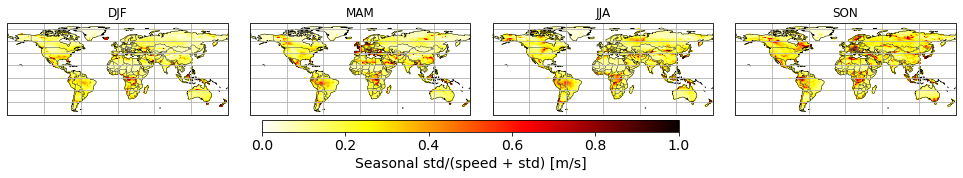

In [50]:
# Set up figure 
fig, axs = plt.subplots(1,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# --- Start plotting ---- 
for iSeason in range(4): 
    axs[iSeason+0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())
    contour_plot = axs[iSeason+0].pcolormesh(lon,lat,STDfraction[iSeason,:,:]*landMask,
                           vmin = 0,
                           vmax = 1, 
                           cmap = 'hot_r')
    axs[iSeason+0].gridlines()
    axs[iSeason+0].coastlines(linewidth=0.5,edgecolor='0.25')
    axs[iSeason+0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
    axs[iSeason+0].set_title(seasonalTitles[iSeason])
    
    # Add colorbar 
    if iSeason==1: 
        ax_position = axs[iSeason].get_position()
        cbar_ax     = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.03, ax_position.width+0.16, 0.02])
        cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
        # Control number of ticks via 'ticker' in matplotlib 
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        # Set label and fontsize
        cbar.set_label('Seasonal std/(speed + std) [m/s]',fontsize=14)
        cbar.ax.tick_params(labelsize=14)
    

## Regional 2D histograms

In [223]:
# Create 3D mask of the SRX regions 
RegMask = regionmask.defined_regions.srex.mask_3D(lon, lat)


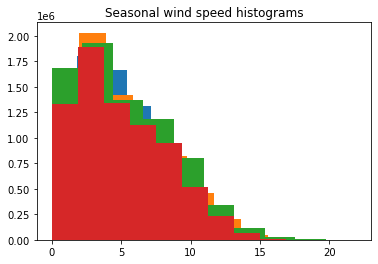

In [44]:
# Reasonable limits? 
plt.hist(sfcWindSpd[iDJF,:,:].reshape([len(lat)*len(lon)*len(iDJF),1]))
plt.hist(sfcWindSpd[iMAM,:,:].reshape([len(lat)*len(lon)*len(iMAM), 1]))
plt.hist(sfcWindSpd[iJJA,:,:].reshape([len(lat)*len(lon)*len(iJJA),1]))
plt.hist(sfcWindSpd[iSON,:,:].reshape([len(lat)*len(lon)*len(iSON),1]))
plt.title('Seasonal wind speed histograms')
plt.show()


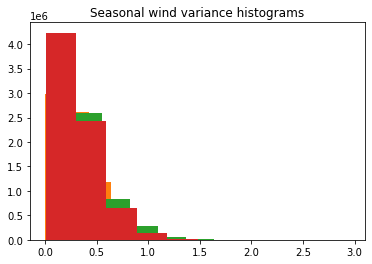

In [202]:
# Reasonable limits? 
plt.hist(sfcWindVar[iDJF,:,:].reshape([len(lat)*len(lon)*len(iDJF),1]))
plt.hist(sfcWindVar[iMAM,:,:].reshape([len(lat)*len(lon)*len(iMAM), 1]))
plt.hist(sfcWindVar[iJJA,:,:].reshape([len(lat)*len(lon)*len(iJJA),1]))
plt.hist(sfcWindVar[iSON,:,:].reshape([len(lat)*len(lon)*len(iSON),1]))
plt.title('Seasonal wind variance histograms')
plt.show()



In [224]:
# Loop over regions... 
nRegions = len(RegMask.region.values)

# Set up bin edges for both vars
wndSpeed_edges   = np.linspace(0,12,31)
wndVar_edges     = np.linspace(0,1.2,31)

# Save output 
H_all_DJF = np.full([nRegions,len(wndSpeed_edges)-1,len(wndVar_edges)-1], np.nan)
H_all_MAM = np.full([nRegions,len(wndSpeed_edges)-1,len(wndVar_edges)-1], np.nan)
H_all_JJA = np.full([nRegions,len(wndSpeed_edges)-1,len(wndVar_edges)-1], np.nan)
H_all_SON = np.full([nRegions,len(wndSpeed_edges)-1,len(wndVar_edges)-1], np.nan)

for iReg in range(nRegions): 
    # Get indices of selected region 
    rSel = RegMask.sel(region=iReg+1)
    rMask = np.full([len(lat),len(lon)],np.nan)
    rMask[rSel==True] = 1 
    
    # Select arrays seasonally 
    spd_regSel_DJF = sfcWindSpd[iDJF,:,:]*rMask*landMask
    spd_regSel_MAM = sfcWindSpd[iMAM,:,:]*rMask*landMask
    spd_regSel_JJA = sfcWindSpd[iJJA,:,:]*rMask*landMask
    spd_regSel_SON = sfcWindSpd[iSON,:,:]*rMask*landMask
    
    var_regSel_DJF = sfcWindVar[iDJF,:,:]*rMask*landMask
    var_regSel_MAM = sfcWindVar[iMAM,:,:]*rMask*landMask
    var_regSel_JJA = sfcWindVar[iJJA,:,:]*rMask*landMask
    var_regSel_SON = sfcWindVar[iSON,:,:]*rMask*landMask
        
    # Flatten the arrays over space & time for these regions (histograms compute quicker)
    spd_regSel_DJF = spd_regSel_DJF.reshape([len(lon)*len(lat)*len(iDJF)])
    spd_regSel_MAM = spd_regSel_MAM.reshape([len(lon)*len(lat)*len(iMAM)])
    spd_regSel_JJA = spd_regSel_JJA.reshape([len(lon)*len(lat)*len(iJJA)])
    spd_regSel_SON = spd_regSel_SON.reshape([len(lon)*len(lat)*len(iSON)])
    
    var_regSel_DJF = var_regSel_DJF.reshape([len(lon)*len(lat)*len(iDJF)])
    var_regSel_MAM = var_regSel_MAM.reshape([len(lon)*len(lat)*len(iMAM)])
    var_regSel_JJA = var_regSel_JJA.reshape([len(lon)*len(lat)*len(iJJA)])
    var_regSel_SON = var_regSel_SON.reshape([len(lon)*len(lat)*len(iSON)])
    
    
    # Get 2D hist info 
    H_reg_DJF, wndSpeed_edges, wndVar_edges = np.histogram2d(spd_regSel_DJF, var_regSel_DJF, bins=(wndSpeed_edges, wndVar_edges))
    H_reg_MAM, wndSpeed_edges, wndVar_edges = np.histogram2d(spd_regSel_MAM, var_regSel_MAM, bins=(wndSpeed_edges, wndVar_edges))
    H_reg_JJA, wndSpeed_edges, wndVar_edges = np.histogram2d(spd_regSel_JJA, var_regSel_JJA, bins=(wndSpeed_edges, wndVar_edges))
    H_reg_SON, wndSpeed_edges, wndVar_edges = np.histogram2d(spd_regSel_SON, var_regSel_SON, bins=(wndSpeed_edges, wndVar_edges))
    
    # Save all regions to large array 
    H_all_DJF[iReg,:,:] = H_reg_DJF.T  # Let each row list bins with common y range (part of how this function works)
    H_all_MAM[iReg,:,:] = H_reg_MAM.T
    H_all_JJA[iReg,:,:] = H_reg_JJA.T
    H_all_SON[iReg,:,:] = H_reg_SON.T
    

### Plotting

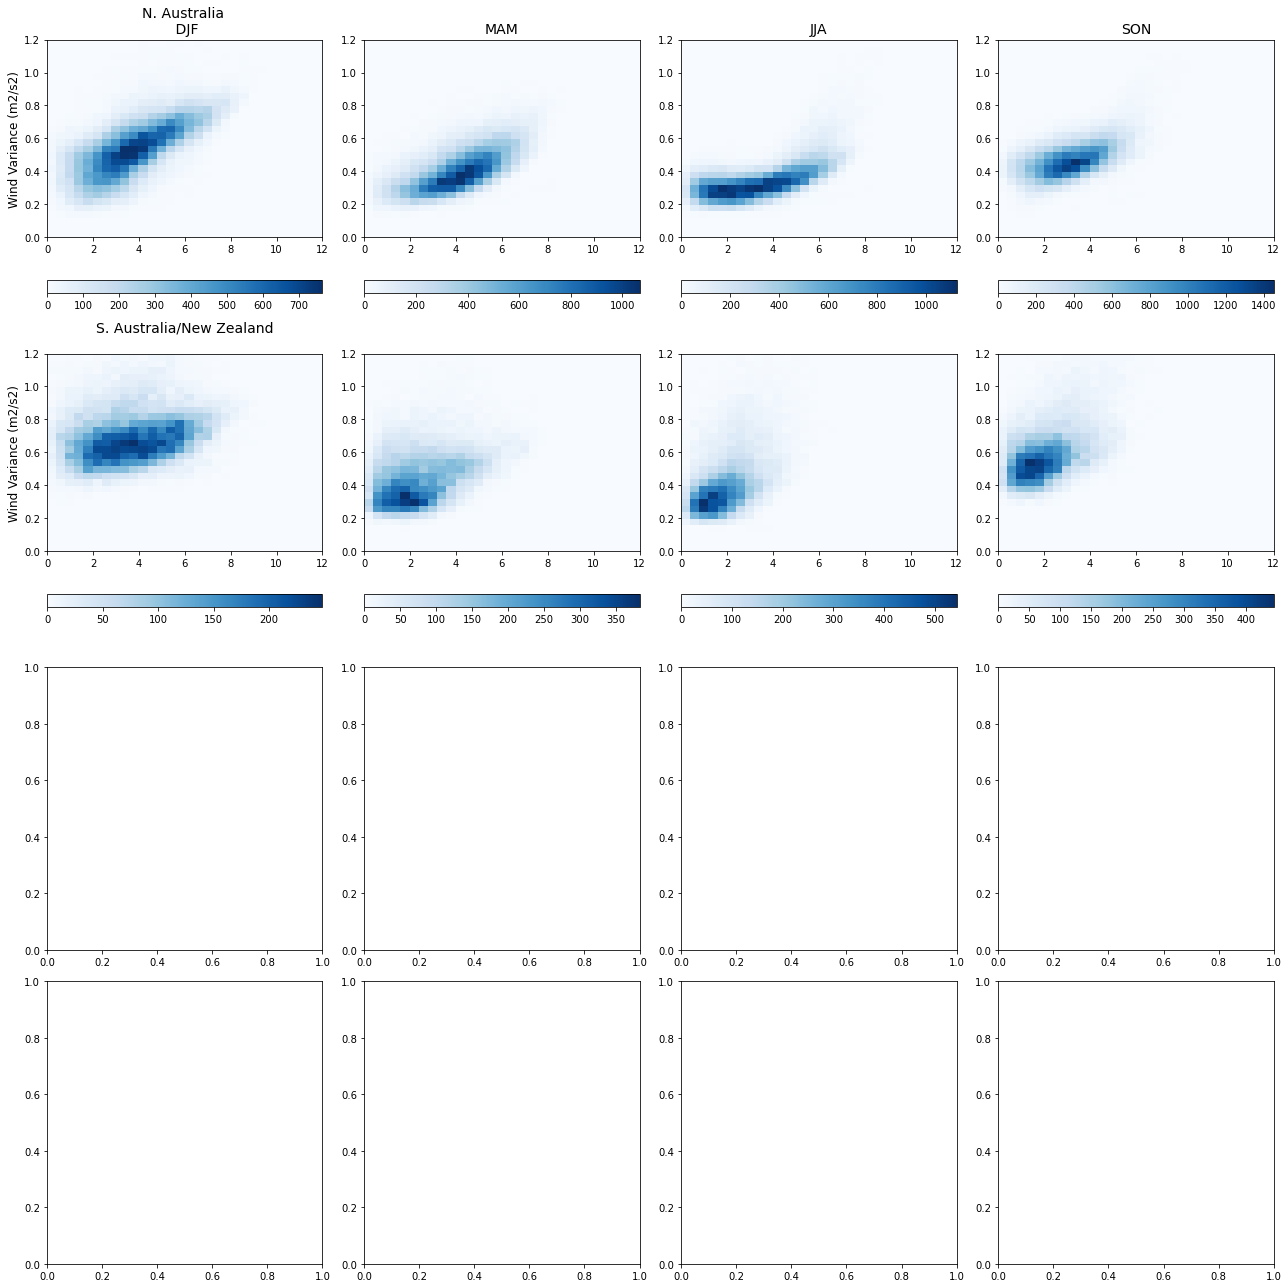

In [229]:
# Set up figure 
fig, axs = plt.subplots(4,4, figsize=(18, 18))
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.3)
#Put axs handles in array, axs 
axs = axs.ravel()

# Get X,Y=binedges as meshgrid for plotting purposes 
X,Y = np.meshgrid(wndSpeed_edges, wndVar_edges)

groupID   = 6          # Plotting in groups of 4 regions at a time, so use this ID 
regOffset = 4*groupID   # To change group of regions being plotted (increments of 4) 
pltInd    = 0           # To change plot index by season as well as region 

for iReg in range(2):
    
    # Plot data ----------------------------------------------
    
    # Plot DJF 
    pPlot = axs[pltInd+0].pcolormesh(X,Y, H_all_DJF[iReg+regOffset,:,:],cmap='Blues')
    fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+0])
    
    # Plot MAM 
    pPlot=axs[pltInd+1].pcolormesh(X,Y, H_all_MAM[iReg+regOffset,:,:],cmap='Blues')
    # Use colorbar label only on bottom 
    if iReg==3:
        cb=fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+1])
        cb.set_label('Density of gridcells in range',x=1.2,fontsize=14)
    else:
        fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+1])

    # Plot JJA 
    pPlot=axs[pltInd+2].pcolormesh(X,Y, H_all_JJA[iReg+regOffset,:,:],cmap='Blues')
    fig.colorbar(pPlot, orientation='horizontal',ax=axs[pltInd+2])
    
    
    # Plot SON 
    pPlot=axs[pltInd+3].pcolormesh(X,Y, H_all_SON[iReg+regOffset,:,:],cmap='Blues')
    fig.colorbar(pPlot, orientation='horizontal',ax=axs[pltInd+3])
    
    # ----------------------------------------------

    # Set plot titles 
    if iReg==0:
        axs[pltInd+0].set_title(RegMask.names.values[iReg+regOffset]+' \n DJF',fontsize=14)
        axs[pltInd+1].set_title('MAM',fontsize=14)
        axs[pltInd+2].set_title('JJA',fontsize=14)
        axs[pltInd+3].set_title('SON',fontsize=14)
    else:
        axs[pltInd+0].set_title(RegMask.names.values[iReg+regOffset]+'\n ', fontsize=14)
        
    # Set axis labels only for outside plots 
    axs[pltInd+0].set_ylabel('Wind Variance (m2/s2)',fontsize=12)
    
    if iReg==3: 
        axs[pltInd+0].set_xlabel('Sfc Wind Speed (m/s)', fontsize=12)
        axs[pltInd+1].set_xlabel('Sfc Wind Speed (m/s)', fontsize=12)
        axs[pltInd+2].set_xlabel('Sfc Wind Speed (m/s)', fontsize=12)
        axs[pltInd+3].set_xlabel('Sfc Wind Speed (m/s)', fontsize=12)  

    plt.tight_layout(h_pad=1)
    # Increment plot index for next region 
    pltInd = pltInd+4
    
    
# ****  Be sure to change figure title before running  ****** 
# fileDir = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/Figures/'
# fig.savefig(fileDir+'wndSpd-wndVar_2Dhistogram_regionalSet-'+str(groupID+1)+'-LAND_only.pdf')
# *****         *****        *****        ****         *******
    

## Let's maybe dig into an interesting region or two... 

### Can we get slope of linear regression line?

In [242]:
H_JJA_reg[:,2]

array([2.401e+03, 3.725e+03, 3.052e+03, 2.302e+03, 1.434e+03, 9.130e+02,
       6.550e+02, 5.390e+02, 5.580e+02, 6.600e+02, 6.410e+02, 6.590e+02,
       6.870e+02, 6.130e+02, 5.470e+02, 4.080e+02, 3.430e+02, 2.560e+02,
       1.800e+02, 1.100e+02, 7.400e+01, 4.600e+01, 3.000e+01, 1.400e+01,
       1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])

In [ ]:
from scipy.optimize import curve_fit


def fit_function(x, A, B):
    return ((A * x) + B)

popt, pcov = curve_fit(fit_function, xdata=binscenters, ydata=data_entries, p0=[20000, 2.0, 2000, 3.0, 0.3])
print(popt)


In [228]:
np.shape(wndSpeed_edges)

(31,)

In [225]:
np.shape(H_all_JJA)

(26, 30, 30)

### Start with maybe some maps in winter/summer of region 1 (AK/NW Canada)

In [197]:
# Get indices of selected region 
rSel = RegMask.sel(region=2)
rMask = np.full([len(lat),len(lon)],np.nan)
rMask[rSel==True] = 1 

# Select arrays seasonally 
spd_reg1_DJF = sfcWindSpd[iDJF,:,:]*rMask
spd_reg1_JJA = sfcWindSpd[iJJA,:,:]*rMask

var_reg1_DJF = sfcWindVar[iDJF,:,:]*rMask
var_reg1_JJA = sfcWindVar[iJJA,:,:]*rMask



In [198]:
# Get sfc U and V components too 
U_reg1_DJF = U[iDJF,0,:,:]*rMask
U_reg1_JJA = U[iJJA,0,:,:]*rMask
V_reg1_DJF = V[iDJF,0,:,:]*rMask
V_reg1_JJA = V[iJJA,0,:,:]*rMask


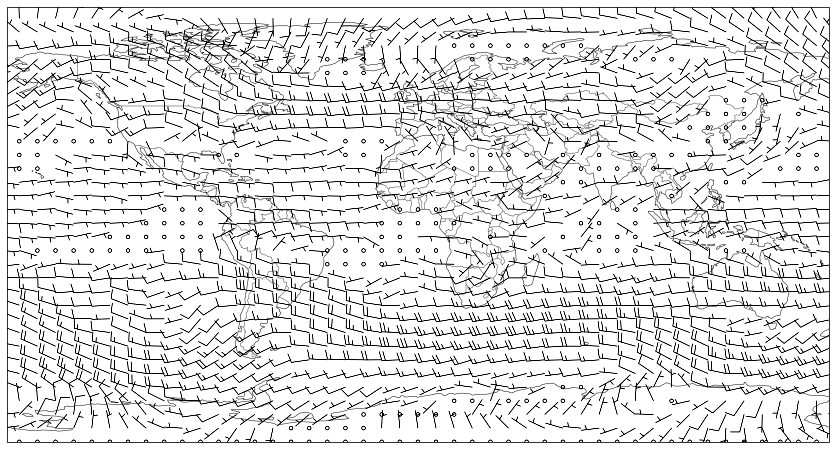

In [91]:
# # Want to make sure barbs works how I think it should...
# Utest = U[30, 11, :,:]
# Vtest = V[30, 11, :,:]

# # Set up figure 
# fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
#                         facecolor='w', edgecolor='k',
#                         subplot_kw={'projection':ccrs.PlateCarree()})

# # Set limits of plot
# ax1.set_extent([-170, 170, -90, 90], crs=ccrs.PlateCarree())

# ax1.coastlines(linewidth=0.5,edgecolor='0.25')
# ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# # --- Yep! Plot every other grid in lat/lon to make it viewable 
# skipLon = np.arange(0, len(lon), 6)
# skipLat = np.arange(0, len(lat), 6)

# skippedU_DJF = Utest[skipLat,:]
# skippedU_DJF = skippedU_DJF[:,skipLon]
# skippedV_DJF = Vtest[skipLat,:]
# skippedV_DJF = skippedV_DJF[:,skipLon]

# ax1.barbs(lon[skipLon], lat[skipLat],
#              skippedU_DJF, skippedV_DJF, 
#              length=6,
#              pivot='tip',
#              sizes=dict(emptybarb=0.1, spacing=.2, height=0.5), 
#              zorder=20, linewidth=0.5,
#              transform= ccrs.PlateCarree())


# plt.show()


<ipython-input-199-cbb30fac5ca4>:20: RuntimeWarning: Mean of empty slice
  contour_plot = axs[0].pcolormesh(lon,lat, (np.nanmean(spd_reg1_DJF,axis=0)),
<ipython-input-199-cbb30fac5ca4>:50: RuntimeWarning: Mean of empty slice
  skippedU_DJF = (np.nanmean(U_reg1_DJF, axis=0)*landMask)[skipLat,:]
<ipython-input-199-cbb30fac5ca4>:52: RuntimeWarning: Mean of empty slice
  skippedV_DJF = (np.nanmean(V_reg1_DJF, axis=0)*landMask)[skipLat,:]
<ipython-input-199-cbb30fac5ca4>:67: RuntimeWarning: Mean of empty slice
  contour_plot = axs[1].pcolormesh(lon,lat, (np.nanmean(spd_reg1_JJA,axis=0)),
<ipython-input-199-cbb30fac5ca4>:97: RuntimeWarning: Mean of empty slice
  skippedU_JJA = (np.nanmean(U_reg1_JJA, axis=0)*landMask)[skipLat,:]
<ipython-input-199-cbb30fac5ca4>:99: RuntimeWarning: Mean of empty slice
  skippedV_JJA = (np.nanmean(V_reg1_JJA, axis=0)*landMask)[skipLat,:]


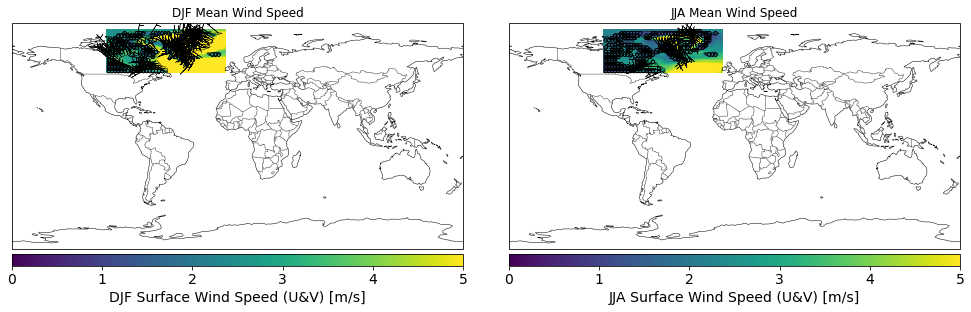

In [199]:
# Now see about mapping it out 

# Set up figure 
fig, axs = plt.subplots(1,2, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Set limits of plot
# axs[0].set_extent([-170, -100, 55, 80], crs=ccrs.PlateCarree())
# axs[1].set_extent([-170, -100, 55, 80], crs=ccrs.PlateCarree())


# ======================== DJF ==========================================

# Plot mean wind speed 
contour_plot = axs[0].pcolormesh(lon,lat, (np.nanmean(spd_reg1_DJF,axis=0)),
                       vmin = 0,
                       vmax = 5, 
                       cmap = 'viridis')

axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[0].set_title('DJF Mean Wind Speed')

    
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
# Set label and fontsize
cbar.set_label('DJF Surface Wind Speed (U&V) [m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# ================================
#   Add wind vectors 
# ================================
# Plot every other grid in lat/lon to make it viewable 
skipLon = np.arange(0, len(lon), 2)
skipLat = np.arange(0, len(lat), 2)

# Get mean U and V
skippedU_DJF = (np.nanmean(U_reg1_DJF, axis=0)*landMask)[skipLat,:]
skippedU_DJF = skippedU_DJF[:,skipLon]
skippedV_DJF = (np.nanmean(V_reg1_DJF, axis=0)*landMask)[skipLat,:]
skippedV_DJF = skippedV_DJF[:,skipLon]

axs[0].barbs(lon[skipLon], lat[skipLat],
             skippedU_DJF, skippedV_DJF, 
             length=6,
             pivot='tip',
             sizes=dict(emptybarb=0.1, spacing=.2, height=0.5), 
             zorder=20, linewidth=0.5,
             transform= ccrs.PlateCarree())


# ========================== JJA ================================

# Plot mean wind speed 
contour_plot = axs[1].pcolormesh(lon,lat, (np.nanmean(spd_reg1_JJA,axis=0)),
                       vmin = 0,
                       vmax = 5, 
                       cmap = 'viridis')

axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].set_title('JJA Mean Wind Speed')

    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
# Set label and fontsize
cbar.set_label('JJA Surface Wind Speed (U&V) [m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# ================================
#   Add wind vectors 
# ================================
# Plot every other grid in lat/lon to make it viewable 
skipLon = np.arange(0, len(lon), 2)
skipLat = np.arange(0, len(lat), 2)

# Get mean U and V
skippedU_JJA = (np.nanmean(U_reg1_JJA, axis=0)*landMask)[skipLat,:]
skippedU_JJA = skippedU_JJA[:,skipLon]
skippedV_JJA = (np.nanmean(V_reg1_JJA, axis=0)*landMask)[skipLat,:]
skippedV_JJA = skippedV_JJA[:,skipLon]

axs[1].barbs(lon[skipLon], lat[skipLat],
             skippedU_JJA, skippedV_JJA, 
             length=6,
             pivot='tip',
             sizes=dict(emptybarb=0.1, spacing=.2, height=0.5), 
             zorder=20, linewidth=0.5,
             transform= ccrs.PlateCarree())


plt.show()


<ipython-input-95-41429fb6b142>:44: RuntimeWarning: Mean of empty slice
  contour_plot = axs[0].pcolormesh(lon,lat, (np.nanmean(spd_reg1_DJF,axis=0))*landMask,
<ipython-input-95-41429fb6b142>:74: RuntimeWarning: Mean of empty slice
  skippedU_DJF = (np.nanmean(U_reg1_DJF, axis=0)*landMask)[skipLat,:]
<ipython-input-95-41429fb6b142>:76: RuntimeWarning: Mean of empty slice
  skippedV_DJF = (np.nanmean(V_reg1_DJF, axis=0)*landMask)[skipLat,:]
<ipython-input-95-41429fb6b142>:91: RuntimeWarning: Mean of empty slice
  contour_plot = axs[1].pcolormesh(lon,lat, (np.nanmean(spd_reg1_JJA,axis=0))*landMask,
<ipython-input-95-41429fb6b142>:121: RuntimeWarning: Mean of empty slice
  skippedU_JJA = (np.nanmean(U_reg1_JJA, axis=0)*landMask)[skipLat,:]
<ipython-input-95-41429fb6b142>:123: RuntimeWarning: Mean of empty slice
  skippedV_JJA = (np.nanmean(V_reg1_JJA, axis=0)*landMask)[skipLat,:]


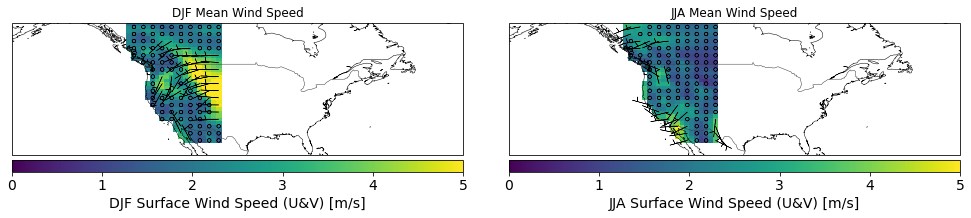

In [95]:
# Try this for somewhere less polar... 
# Western North America, Region = 3 

# Get indices of selected region 
rSel = RegMask.sel(region=3)
rMask = np.full([len(lat),len(lon)],np.nan)
rMask[rSel==True] = 1 

# Select arrays seasonally 
spd_reg1_DJF = sfcWindSpd[iDJF,:,:]*rMask
spd_reg1_JJA = sfcWindSpd[iJJA,:,:]*rMask

var_reg1_DJF = sfcWindVar[iDJF,:,:]*rMask
var_reg1_JJA = sfcWindVar[iJJA,:,:]*rMask


# Get sfc U and V components too 
U_reg1_DJF = U[iDJF,0,:,:]*rMask
U_reg1_JJA = U[iJJA,0,:,:]*rMask
V_reg1_DJF = V[iDJF,0,:,:]*rMask
V_reg1_JJA = V[iJJA,0,:,:]*rMask



# Now see about mapping it out 

# Set up figure 
fig, axs = plt.subplots(1,2, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Set limits of plot
axs[0].set_extent([-160, -40, 25, 60], crs=ccrs.PlateCarree())
axs[1].set_extent([-160, -40, 25, 60], crs=ccrs.PlateCarree())


# ======================== DJF ==========================================

# Plot mean wind speed 
contour_plot = axs[0].pcolormesh(lon,lat, (np.nanmean(spd_reg1_DJF,axis=0))*landMask,
                       vmin = 0,
                       vmax = 5, 
                       cmap = 'viridis')

axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[0].set_title('DJF Mean Wind Speed')

    
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
# Set label and fontsize
cbar.set_label('DJF Surface Wind Speed (U&V) [m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# ================================
#   Add wind vectors 
# ================================
# Plot every other grid in lat/lon to make it viewable 
skipLon = np.arange(0, len(lon), 2)
skipLat = np.arange(0, len(lat), 2)

# Get mean U and V
skippedU_DJF = (np.nanmean(U_reg1_DJF, axis=0)*landMask)[skipLat,:]
skippedU_DJF = skippedU_DJF[:,skipLon]
skippedV_DJF = (np.nanmean(V_reg1_DJF, axis=0)*landMask)[skipLat,:]
skippedV_DJF = skippedV_DJF[:,skipLon]

axs[0].barbs(lon[skipLon], lat[skipLat],
             skippedU_DJF, skippedV_DJF, 
             length=6,
             pivot='tip',
             sizes=dict(emptybarb=0.1, spacing=.2, height=0.5), 
             zorder=20, linewidth=0.5,
             transform= ccrs.PlateCarree())


# ========================== JJA ================================

# Plot mean wind speed 
contour_plot = axs[1].pcolormesh(lon,lat, (np.nanmean(spd_reg1_JJA,axis=0))*landMask,
                       vmin = 0,
                       vmax = 5, 
                       cmap = 'viridis')

axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].set_title('JJA Mean Wind Speed')

    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
# Set label and fontsize
cbar.set_label('JJA Surface Wind Speed (U&V) [m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# ================================
#   Add wind vectors 
# ================================
# Plot every other grid in lat/lon to make it viewable 
skipLon = np.arange(0, len(lon), 2)
skipLat = np.arange(0, len(lat), 2)

# Get mean U and V
skippedU_JJA = (np.nanmean(U_reg1_JJA, axis=0)*landMask)[skipLat,:]
skippedU_JJA = skippedU_JJA[:,skipLon]
skippedV_JJA = (np.nanmean(V_reg1_JJA, axis=0)*landMask)[skipLat,:]
skippedV_JJA = skippedV_JJA[:,skipLon]

axs[1].barbs(lon[skipLon], lat[skipLat],
             skippedU_JJA, skippedV_JJA, 
             length=6,
             pivot='tip',
             sizes=dict(emptybarb=0.1, spacing=.2, height=0.5), 
             zorder=20, linewidth=0.5,
             transform= ccrs.PlateCarree())


plt.show()




### Don't love that approach

In [97]:
iReg = 8     # NE Brazil 

# Get indices of selected region 
rSel = RegMask.sel(region=iReg)
rMask = np.full([len(lat),len(lon)],np.nan)
rMask[rSel==True] = 1 

# Select arrays seasonally 
spd_regSel_DJF = sfcWindSpd[iDJF,:,:]*rMask
spd_regSel_MAM = sfcWindSpd[iMAM,:,:]*rMask
spd_regSel_JJA = sfcWindSpd[iJJA,:,:]*rMask
spd_regSel_SON = sfcWindSpd[iSON,:,:]*rMask

var_regSel_DJF = sfcWindVar[iDJF,:,:]*rMask
var_regSel_MAM = sfcWindVar[iMAM,:,:]*rMask
var_regSel_JJA = sfcWindVar[iJJA,:,:]*rMask
var_regSel_SON = sfcWindVar[iSON,:,:]*rMask


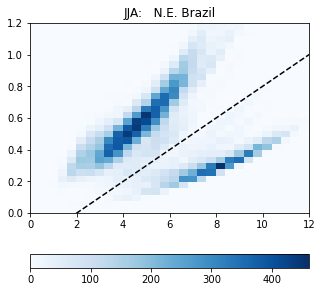

In [149]:
## The two regimes... 
# Let's start with JJA...

fig, ax1 = plt.subplots(1,1, figsize=(5, 5))
# Get X,Y=binedges as meshgrid for plotting purposes 
X,Y = np.meshgrid(wndSpeed_edges, wndVar_edges)

pPlot = ax1.pcolormesh(X,Y, H_all_JJA[iReg-1,:,:],cmap='Blues')
fig.colorbar(pPlot, orientation='horizontal',ax=ax1)
ax1.set_title('JJA:   '+RegMask.names.values[iReg-1])


# Define 1:1 line that would separate out data
x = np.linspace(0,np.max(wndSpeed_edges),50)
y = (0.1*x) + -0.2
ax1.plot(x,y,'k--')
ax1.set_ylim([0,1.2])
        


In [177]:
# So want to get values in one half vs. another... 
conditionalSelection = np.zeros([len(iJJA), len(lat), len(lon)])

for ii in range(len(lat)):
    for jj in range(len(lon)):
        regTimeSeries_var = var_regSel_JJA[:,ii,jj]
        regTimeSeries_spd = spd_regSel_JJA[:,ii,jj]
        
        # Compute y-value (var) if that line equation were valid 
        yEquation = (0.1*regTimeSeries_spd) - 0.2
        
        # Get indices for times at lat/lon that fall above the line
        iGT = np.where(regTimeSeries_var > yEquation)[0]
        if len(iGT)>0:
            conditionalSelection[iGT,ii,jj] = 1
        

In [178]:
conditionalSelection[:,94,253]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

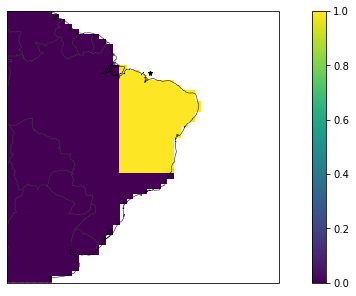

In [189]:
# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(12, 5), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

condMap = ax1.pcolormesh(lon,lat,np.nanmean(conditionalSelection, axis=0)*landMask)
#condMap = ax1.pcolormesh(lon,lat,conditionalSelection[10,:,:]*landMask)
# Set limits of plot
ax1.set_extent([-70, -20, -40, 10], crs=ccrs.PlateCarree())
ax1.plot(lon[253],lat[94],'k*',markersize=5,transform=ccrs.PlateCarree())

ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
plt.colorbar(condMap)


135


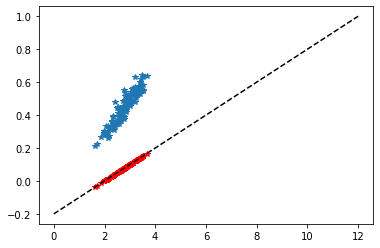

In [155]:
# Sanity check to make sure the method works... 

# Pick out location 
testVar = var_regSel_JJA[:,91,250]
testSpd = spd_regSel_JJA[:,91,250]
# testVar = var_regSel_JJA[:,94,253]
# testSpd = spd_regSel_JJA[:,94,253]

# If equation were true, what would y-values be?
yEquation = (0.1*testSpd) - 0.2
# Get indices 
iGT = np.where(testVar > yEquation)[0]
print(len(iGT))
# Plot points along with separating line 
plt.plot(testSpd,testVar,'*')
plt.plot(testSpd,yEquation,'r*')
plt.plot(x,y,'k--')


In [170]:
len(iJJA)

135

## Is there a way to combine with information about PBLH? 

In [243]:
# Loop over regions... 
nRegions = len(RegMask.region.values)

# Set up bin edges for both vars
wndSpeed_edges   = np.linspace(0,12,31)
PBLH_edges = np.linspace(200,1400,31)

# Save output 
H_all_DJF_PBLH = np.full([nRegions,len(wndSpeed_edges)-1,len(PBLH_edges)-1], np.nan)
H_all_MAM_PBLH = np.full([nRegions,len(wndSpeed_edges)-1,len(PBLH_edges)-1], np.nan)
H_all_JJA_PBLH = np.full([nRegions,len(wndSpeed_edges)-1,len(PBLH_edges)-1], np.nan)
H_all_SON_PBLH = np.full([nRegions,len(wndSpeed_edges)-1,len(PBLH_edges)-1], np.nan)

for iReg in range(nRegions): 
    # Get indices of selected region 
    rSel = RegMask.sel(region=iReg+1)
    rMask = np.full([len(lat),len(lon)],np.nan)
    rMask[rSel==True] = 1 
    
    # Select arrays seasonally 
    spd_regSel_DJF = sfcWindSpd[iDJF,:,:]*rMask
    spd_regSel_MAM = sfcWindSpd[iMAM,:,:]*rMask
    spd_regSel_JJA = sfcWindSpd[iJJA,:,:]*rMask
    spd_regSel_SON = sfcWindSpd[iSON,:,:]*rMask
    
    PBLH_regSel_DJF = PBLH[iDJF,:,:]*rMask
    PBLH_regSel_MAM = PBLH[iMAM,:,:]*rMask
    PBLH_regSel_JJA = PBLH[iJJA,:,:]*rMask
    PBLH_regSel_SON = PBLH[iSON,:,:]*rMask
        
    # Flatten the arrays over space for these regions/seasons (histograms compute quicker)
    spd_regSel_DJF = spd_regSel_DJF.reshape([len(lon)*len(lat)*len(iDJF)])
    spd_regSel_MAM = spd_regSel_MAM.reshape([len(lon)*len(lat)*len(iMAM)])
    spd_regSel_JJA = spd_regSel_JJA.reshape([len(lon)*len(lat)*len(iJJA)])
    spd_regSel_SON = spd_regSel_SON.reshape([len(lon)*len(lat)*len(iSON)])
    
    PBLH_regSel_DJF = PBLH_regSel_DJF.reshape([len(lon)*len(lat)*len(iDJF)])
    PBLH_regSel_MAM = PBLH_regSel_MAM.reshape([len(lon)*len(lat)*len(iMAM)])
    PBLH_regSel_JJA = PBLH_regSel_JJA.reshape([len(lon)*len(lat)*len(iJJA)])
    PBLH_regSel_SON = PBLH_regSel_SON.reshape([len(lon)*len(lat)*len(iSON)])
    
    
    # Get 2D hist info 
    H_reg_DJF, wndSpeed_edges, PBLH_edges = np.histogram2d(spd_regSel_DJF, PBLH_regSel_DJF, bins=(wndSpeed_edges, PBLH_edges))
    H_reg_MAM, wndSpeed_edges, PBLH_edges = np.histogram2d(spd_regSel_MAM, PBLH_regSel_MAM, bins=(wndSpeed_edges, PBLH_edges))
    H_reg_JJA, wndSpeed_edges, PBLH_edges = np.histogram2d(spd_regSel_JJA, PBLH_regSel_JJA, bins=(wndSpeed_edges, PBLH_edges))
    H_reg_SON, wndSpeed_edges, PBLH_edges = np.histogram2d(spd_regSel_SON, PBLH_regSel_SON, bins=(wndSpeed_edges, PBLH_edges))
    
    # Save all regions to large array 
    H_all_DJF_PBLH[iReg,:,:] = H_reg_DJF.T  # Let each row list bins with common y range (part of how this function works)
    H_all_MAM_PBLH[iReg,:,:] = H_reg_MAM.T
    H_all_JJA_PBLH[iReg,:,:] = H_reg_JJA.T
    H_all_SON_PBLH[iReg,:,:] = H_reg_SON.T
    

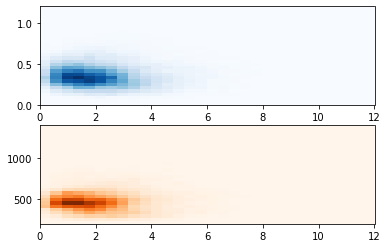

In [34]:
iReg = 3

X,Y     = np.meshgrid(wndSpeed_edges, wndVar_edges)
Xpb,Ypb = np.meshgrid(wndSpeed_edges, PBLH_edges)


fig, axs = plt.subplots(2,1)
axs = axs.ravel()

axs[0].pcolormesh(X,Y, H_all_DJF[iReg,:,:],         cmap='Blues',alpha=1)
axs[1].pcolormesh(Xpb,Ypb, H_all_DJF_PBLH[iReg,:,:],cmap='Oranges',alpha=1)
#ax2.pcolormesh(Xpb,Ypb, H_all_DJF_PBLH[iReg,:,:],cmap='Oranges',alpha=0.7)



In [254]:
PBLH_edges

array([ 200.,  240.,  280.,  320.,  360.,  400.,  440.,  480.,  520.,
        560.,  600.,  640.,  680.,  720.,  760.,  800.,  840.,  880.,
        920.,  960., 1000., 1040., 1080., 1120., 1160., 1200., 1240.,
       1280., 1320., 1360., 1400.])

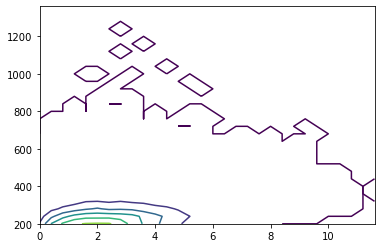

In [248]:
Xpb,Ypb = np.meshgrid(wndSpeed_edges[:-1], PBLH_edges[:-1])
plt.contour(Xpb,Ypb,H_all_DJF_PBLH[0,:,:], levels=5)

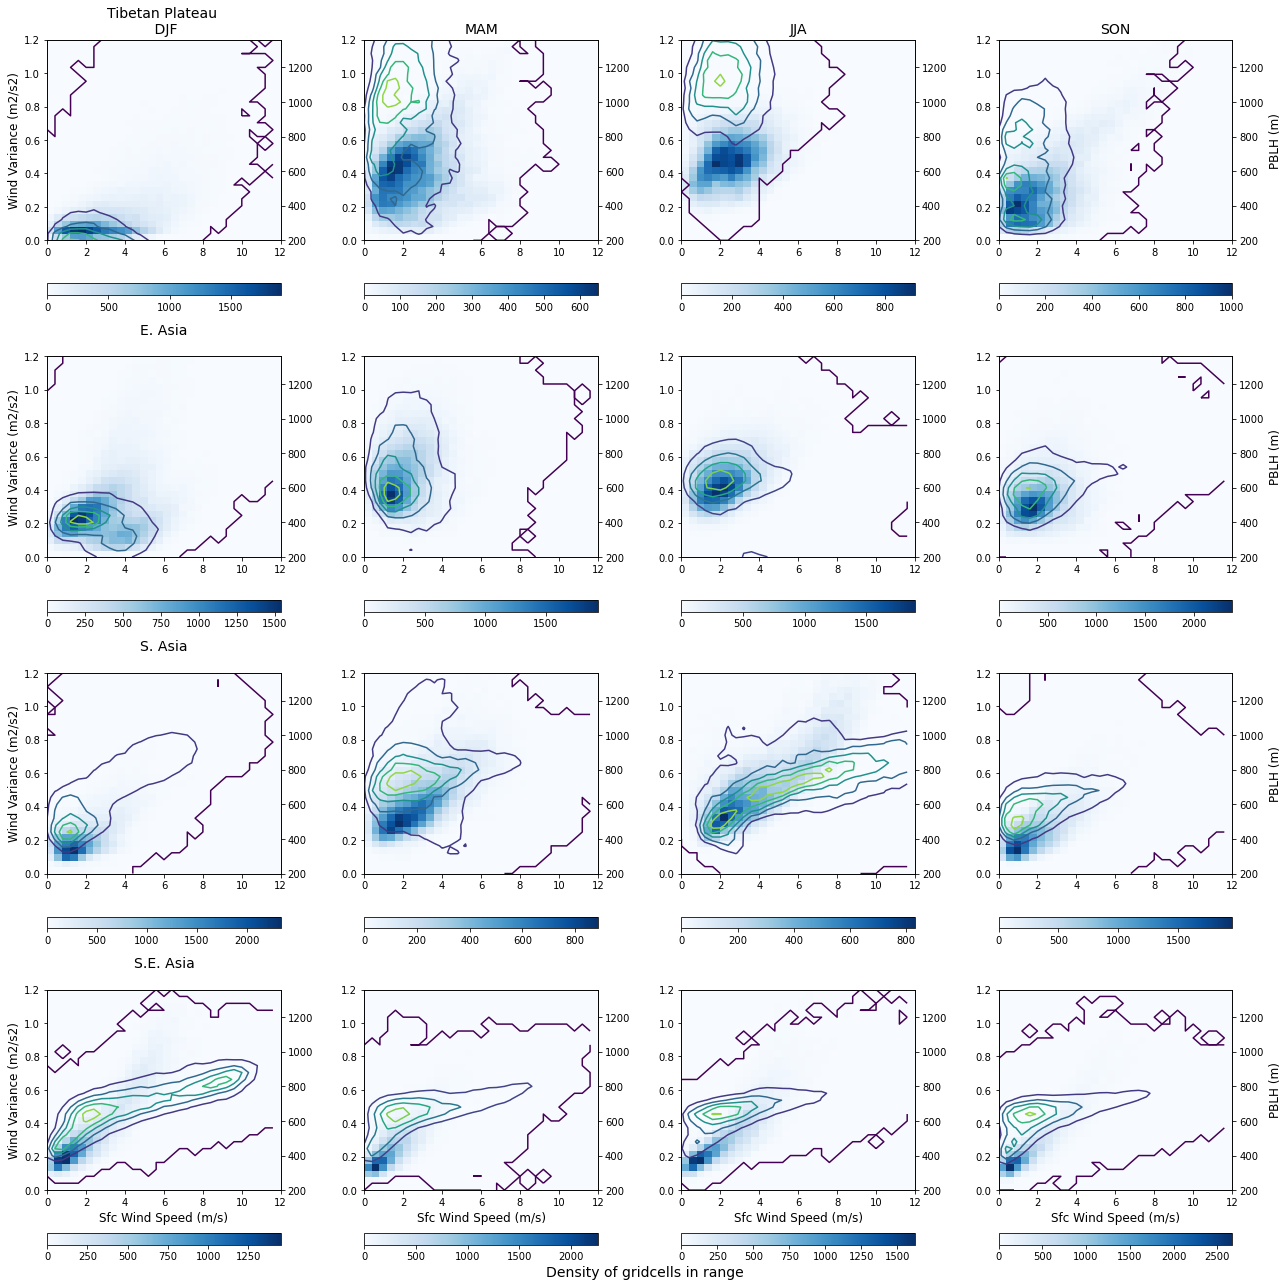

In [265]:
# Set up figure 
fig, axs = plt.subplots(4,4, figsize=(18, 18))
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.3)
#Put axs handles in array, axs 
axs = axs.ravel()

# Get X,Y=binedges as meshgrid for plotting purposes 
X,Y = np.meshgrid(wndSpeed_edges, wndVar_edges)
Xpb,Ypb = np.meshgrid(wndSpeed_edges[:-1], PBLH_edges[:-1])

groupID   = 5           # Plotting in groups of 4 regions at a time, so use this ID 
regOffset = 4*groupID   # To change group of regions being plotted (increments of 4) 
pltInd    = 0           # To change plot index by season as well as region 

for iReg in range(4):
    
    # Plot data ----------------------------------------------
    
    # Plot DJF 
    pPlot = axs[pltInd+0].pcolormesh(X,Y, H_all_DJF[iReg+regOffset,:,:],cmap='Blues')
    fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+0])
    ax2 = axs[pltInd+0].twinx()
    pContour = ax2.contour(Xpb,Ypb,H_all_DJF_PBLH[iReg+regOffset,:,:], levels=5)
    
    # Plot MAM 
    pPlot=axs[pltInd+1].pcolormesh(X,Y, H_all_MAM[iReg+regOffset,:,:],cmap='Blues')
    # Use colorbar label only on bottom 
    if iReg==3:
        cb=fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+1])
        cb.set_label('Density of gridcells in range',x=1.2,fontsize=14)
    else:
        fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+1])
    ax2 = axs[pltInd+1].twinx()
    pContour = ax2.contour(Xpb,Ypb,H_all_MAM_PBLH[iReg+regOffset,:,:], levels=5)

    # Plot JJA 
    pPlot=axs[pltInd+2].pcolormesh(X,Y, H_all_JJA[iReg+regOffset,:,:],cmap='Blues')
    fig.colorbar(pPlot, orientation='horizontal',ax=axs[pltInd+2])
    ax2 = axs[pltInd+2].twinx()
    pContour = ax2.contour(Xpb,Ypb,H_all_JJA_PBLH[iReg+regOffset,:,:], levels=5)
    
    
    # Plot SON 
    pPlot=axs[pltInd+3].pcolormesh(X,Y, H_all_SON[iReg+regOffset,:,:],cmap='Blues')
    fig.colorbar(pPlot, orientation='horizontal',ax=axs[pltInd+3])
    ax2 = axs[pltInd+3].twinx()
    pContour = ax2.contour(Xpb,Ypb,H_all_SON_PBLH[iReg+regOffset,:,:], levels=5)
    
    # ----------------------------------------------

    # Set plot titles 
    if iReg==0:
        axs[pltInd+0].set_title(RegMask.names.values[iReg+regOffset]+' \n DJF',fontsize=14)
        axs[pltInd+1].set_title('MAM',fontsize=14)
        axs[pltInd+2].set_title('JJA',fontsize=14)
        axs[pltInd+3].set_title('SON',fontsize=14)
    else:
        axs[pltInd+0].set_title(RegMask.names.values[iReg+regOffset]+'\n ', fontsize=14)
        
    # Set axis labels only for outside plots 
    axs[pltInd+0].set_ylabel('Wind Variance (m2/s2)',fontsize=12)
    ax2.set_ylabel('PBLH (m)', fontsize=12)
    
    if iReg==3: 
        axs[pltInd+0].set_xlabel('Sfc Wind Speed (m/s)', fontsize=12)
        axs[pltInd+1].set_xlabel('Sfc Wind Speed (m/s)', fontsize=12)
        axs[pltInd+2].set_xlabel('Sfc Wind Speed (m/s)', fontsize=12)
        axs[pltInd+3].set_xlabel('Sfc Wind Speed (m/s)', fontsize=12)  

    plt.tight_layout(h_pad=1)
    # Increment plot index for next region 
    pltInd = pltInd+4
    
    
# # # ****  Be sure to change figure title before running  ****** 
# fileDir = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/Figures/'
# fig.savefig(fileDir+'wndSpd-wndVar_PBLHcontour_regionalSet-'+str(groupID+1)+'.pdf')
# # # *****         *****        *****        ****         *******
    

## Testing/miscellaneous 
* Verify that multiplying a [time,lat,lon] array by a [lat,lon] one does what you think it does...

In [39]:
a = np.ones([2,3,4])*3
b = np.ones([3,4])*2
print(a)
print()
print(b)
print('-----------------')
print(a*b)

[[[3. 3. 3. 3.]
  [3. 3. 3. 3.]
  [3. 3. 3. 3.]]

 [[3. 3. 3. 3.]
  [3. 3. 3. 3.]
  [3. 3. 3. 3.]]]

[[2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]]
-----------------
[[[6. 6. 6. 6.]
  [6. 6. 6. 6.]
  [6. 6. 6. 6.]]

 [[6. 6. 6. 6.]
  [6. 6. 6. 6.]
  [6. 6. 6. 6.]]]


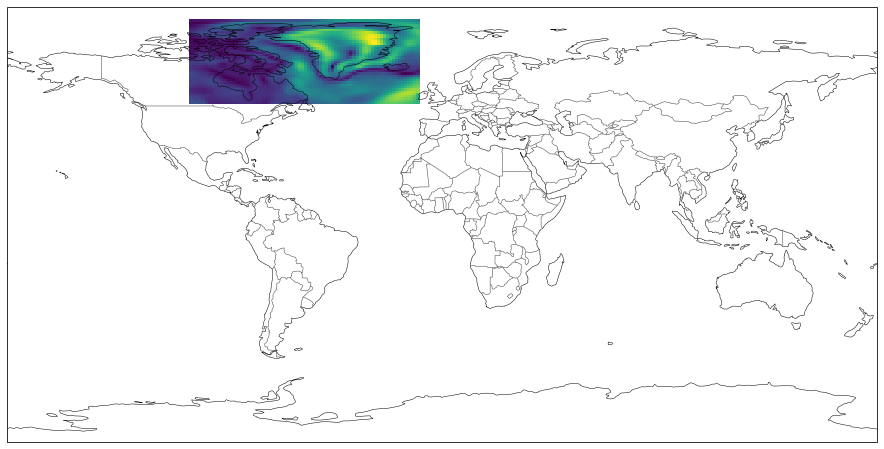

In [43]:
np.shape(sfcWindSpd)
rSel = RegMask.sel(region=2)
rMask = np.full([len(lat),len(lon)],np.nan)
rMask[rSel==True] = 1 

testArr=sfcWindSpd[iDJF,:,:]*rMask


fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
ax1.pcolormesh(lon,lat,testArr[12,:,:])
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
